# Dec 6, 19, 31, 2024: compare the SBM communities with known resting state networks (RSNs), and their sub-networks (independent components (ICs)).

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats, linalg
from scipy.spatial.distance import jensenshannon, cosine
from multiprocessing import Pool
import glob
import random

from sklearn.cluster import DBSCAN, SpectralCoclustering, SpectralClustering
from scipy.optimize import linear_sum_assignment

import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results_v2/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
RSN_ROI_path = f'{ROI_path}/rsns'
os.system(f'mkdir -p {RSN_ROI_path}')
IC_ROI_path = f'{ROI_path}/ics'
os.system(f'mkdir -p {IC_ROI_path}')
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids

marginals_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.08362369337979095, 0.0, 0.0034843205574912...","[[0.7979094076655052, 0.017421602787456445, 0....","[[0.49477351916376305, 0.0, 0.3205574912891986...","[[0.926829268292683, 0.05574912891986063, 0.0,...","[[0.9860627177700348, 0.010452961672473868, 0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.286725,0
1,SLC01,sbm-nd-h,"[[0.06274509803921569, 0.0, 0.0, 0.0, 0.360784...","[[0.8705882352941177, 0.0196078431372549, 0.06...","[[0.5294117647058824, 0.0, 0.30980392156862746...","[[0.9529411764705882, 0.03529411764705882, 0.0...","[[0.9921568627450981, 0.00392156862745098, 0.0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.254538,1
2,SLC01,sbm-nd-h,"[[0.0196078431372549, 0.0, 0.0, 0.0, 0.3431372...","[[0.9901960784313726, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8529411764705882, 0.0, 0.10784313725490197...","[[0.9803921568627451, 0.0196078431372549], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.102439,2
3,SLC01,sbm-nd-h,"[[0.02531645569620253, 0.0, 0.0, 0.0, 0.316455...","[[0.9620253164556962, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.7468354430379747, 0.0, 0.20253164556962025...","[[0.9746835443037974, 0.02531645569620253], [1...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.079128,3
4,SLC01,sbm-nd-h,"[[0.07692307692307693, 0.0, 0.0, 0.0, 0.320512...","[[0.7948717948717948, 0.07692307692307693, 0.0...","[[0.7692307692307693, 0.0, 0.15384615384615385...","[[0.9615384615384616, 0.038461538461538464], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.078369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,SLC10,sbm-nd-h,"[[0.02531645569620253, 0.0, 0.0, 0.0, 0.316455...","[[0.9620253164556962, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.7468354430379747, 0.0, 0.20253164556962025...","[[0.9746835443037974, 0.02531645569620253], [1...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.080736,3
70,SLC10,sbm-nd-h,"[[0.07692307692307693, 0.0, 0.0, 0.0, 0.320512...","[[0.7948717948717948, 0.07692307692307693, 0.0...","[[0.7692307692307693, 0.0, 0.15384615384615385...","[[0.9615384615384616, 0.038461538461538464], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.052651,4
71,SLC10,sbm-nd-h,"[[0.22666666666666666, 0.0, 0.0, 0.0, 0.133333...","[[0.8133333333333334, 0.06666666666666667, 0.0...","[[0.5733333333333334, 0.0, 0.26666666666666666...","[[0.9466666666666667, 0.05333333333333334], [0...","[[0.9733333333333334, 0.02666666666666667], [0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,0.035607,5
72,SLC10,sbm-nd-h,"[[0.09375, 0.0, 0.0, 0.0, 0.078125, 0.0, 0.765...","[[0.734375, 0.0625, 0.078125, 0.0, 0.0, 0.0, 0...","[[0.828125, 0.0, 0.171875], [0.921875, 0.0, 0....","[[0.953125, 0.046875], [0.984375, 0.015625], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,0.017924,6


In [7]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0', 'pi_1', 'pi_2', 'pi_3', 'pi_4', 'pi_5', 'pi_6', 'pi_7', 'pi_8']

similarity with rsns: specificity of a community's overlap with an rsn

In [8]:
nii_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/marginal-visuals/nii/*', recursive=True))
rsn_files = sorted(glob.glob(f'{RSN_ROI_path}/*-mask.nii.gz', recursive=True))

In [9]:
def get_mode_and_level(nii_file):
    mode_level = [n for n in nii_file.split('/') if 'mode-' in n][0].split('.')[0]
    if len(mode_level.split('_')) == 2:
        mode, level = mode_level.split('_')
        mode = int(mode.split('-')[-1])
        level = int(level.split('-')[-1])
        col = f'pi_{level}'
    elif len(mode_level.split('_')) == 1:
        mode = mode_level
        mode = int(mode.split('-')[-1])
        level = 'aligned'
        col = f'pi_{level}'
    
    return col, mode

In [10]:
def find_similarity(comm_vol, sys_vol, metric='specificity', threshold=0.05):
    # how much of the RSN is covered by the community?
    comm_mask = (comm_vol > threshold).astype(int)
    coverage = np.sum((comm_mask) & (sys_vol == 1)) / np.sum(sys_vol)
    coverage = np.nan_to_num(coverage)

    # how much of community's mass falls inside the RSN?
    specificity = np.sum(comm_vol[sys_vol == 1]) / np.sum(comm_vol)
    specificity = np.nan_to_num(specificity)

    # combine the two into single metric
    F1 = 2 * (coverage * specificity) / (coverage + specificity)
    F1 = np.nan_to_num(F1)

    if metric == 'coverage':
        sim = coverage
    if metric == 'specificity':
        sim = specificity
    if metric == 'F1':
        sim = F1
    return sim

def find_similarities_per_sys(nii_vol, ic_vol, metric='specificity'):
    sims = []
    num_comms = nii_vol.shape[-1] if len(nii_vol.shape) == 4 else 1
    for comm in range(num_comms):
        comm_vol = nii_vol[..., comm] if num_comms > 1 else nii_vol
        sim = find_similarity(comm_vol, ic_vol, metric)
        sims += [sim]
    return np.array(sims)

def fill_similarity_matrix(nii_vol, ic_files, metric='specificity'):
    # similarity matrix
    num_comms = nii_vol.shape[-1] if len(nii_vol.shape) == 4 else 1
    X = np.zeros((num_comms, len(ic_files))) # num_comms x num_rsns
    for ic, ic_file in enumerate(ic_files):
        ic_vol = ants.image_read(ic_file).numpy()
        X[:, ic] = find_similarities_per_sys(nii_vol, ic_vol, metric)
    return X

In [11]:
def get_similarity_matrix(nii_files, ic_files, metric='specificity'):
    similarities_df = marginals_df.copy(deep=True)
    for nii_file in tqdm(nii_files):
        sub = [n for n in nii_file.split('/') if 'sub-' in n][0].split('-')[-1]
        col, mode_id = get_mode_and_level(nii_file)

        row = similarities_df[
            (similarities_df['sub'] == sub) &
            (similarities_df['mode_id'] == mode_id)
        ]
        idx = row.index.to_list()[0]

        assert(row['sub'].to_list()[0] == sub)
        assert(row['mode_id'].to_list()[0] == mode_id)

        nii_vol = ants.image_read(nii_file).numpy()
        X = fill_similarity_matrix(nii_vol, ic_files, metric)
        similarities_df.at[idx, col] = X.T # num_ics x num_comms
    return similarities_df

In [12]:
specificities_to_rsns_df = get_similarity_matrix(nii_files, rsn_files, metric='specificity')
specificities_to_rsns_df

100%|██████████| 403/403 [00:30<00:00, 13.04it/s]


,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.6105815172195435, 0.0, 0.00363343697972595...","[[0.32816028594970703, 0.0021414530929178, 0.0...","[[0.10074225068092346, 0.0, 0.165867879986763,...","[[0.1285560131072998, 0.19466650485992432, 0.0...","[[0.13106763362884521, 0.2063291221857071, 0.0...","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,0.286725,0
1,SLC01,sbm-nd-h,"[[0.5741090178489685, 0.0, 0.21176782250404358...","[[0.30934277176856995, 0.0029070358723402023, ...","[[0.10330255329608917, 0.002292242832481861, 0...","[[0.12946143746376038, 0.1738297939300537, 0.0...","[[0.1314481943845749, 0.13680164515972137, 0.0...","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,0.254538,1
2,SLC01,sbm-nd-h,"[[0.5758692026138306, 0.0, 0.21524380147457123...","[[0.2749626040458679, 0.0, 0.01499050017446279...","[[0.1252652257680893, 0.0, 0.17109376192092896...","[[0.13069561123847961, 0.2038051337003708], [0...","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,NaN,0.102439,2
3,SLC01,sbm-nd-h,"[[0.5774957537651062, 0.0, 0.2062569260597229,...","[[0.25768566131591797, 0.006968934088945389, 0...","[[0.11811507493257523, 0.0, 0.1930910944938659...","[[0.1299738883972168, 0.2596296966075897], [0....","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,NaN,0.079128,3
4,SLC01,sbm-nd-h,"[[0.571853756904602, 0.0, 0.20822224020957947,...","[[0.27499961853027344, 0.00535742798820138, 0....","[[0.12223415821790695, 0.0, 0.1618480682373047...","[[0.12999580800533295, 0.19481351971626282], [...","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,NaN,0.078369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,SLC10,sbm-nd-h,"[[0.5774957537651062, 0.0, 0.2062569260597229,...","[[0.25768566131591797, 0.006968934088945389, 0...","[[0.11811507493257523, 0.0, 0.1930910944938659...","[[0.1299738883972168, 0.2596296966075897], [0....","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,NaN,0.080736,3
70,SLC10,sbm-nd-h,"[[0.571853756904602, 0.0, 0.20822224020957947,...","[[0.27499961853027344, 0.00535742798820138, 0....","[[0.12223415821790695, 0.0, 0.1618480682373047...","[[0.12999580800533295, 0.19481351971626282], [...","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,NaN,0.052651,4
71,SLC10,sbm-nd-h,"[[0.602755606174469, 0.0, 0.001632542000152170...","[[0.2895914614200592, 0.004860132932662964, 0....","[[0.10652156919240952, 0.0, 0.1702913343906402...","[[0.12871010601520538, 0.22132974863052368], [...","[[0.1297602355480194, 0.28235143423080444], [0...","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,0.035607,5
72,SLC10,sbm-nd-h,"[[0.5933201313018799, 0.0, 0.00209722528234124...","[[0.31509754061698914, 0.012484253384172916, 0...","[[0.12199310958385468, 0.0, 0.2116395086050033...","[[0.12919002771377563, 0.21975329518318176], [...","[[0.13161501288414001], [0.30769455432891846],...",NaN,NaN,NaN,NaN,0.017924,6


In [13]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

def get_soft_similarity_matrix(similarities_df, num_sys):
    soft_similarities_df = []
    for sub, group in similarities_df.groupby('sub'):
        omegas = group['omega'].to_numpy()
        dct = {'sub': [sub], 'sbm': [SBM]}
        for col in cols:
            M = get_membership_matrix(num_sys, group, col)
            # num_rsns x num_modes x num_comms

            soft_X = np.average(M, axis=1, weights=omegas)
            dct[col] = [soft_X]
        soft_similarities_df += [pd.DataFrame(dct)]
    soft_similarities_df = pd.concat(soft_similarities_df).reset_index(drop=True)
    return soft_similarities_df

In [14]:
soft_specificities_to_rsns_df = get_soft_similarity_matrix(specificities_to_rsns_df, len(rsn_files))
soft_specificities_to_rsns_df

,sub,sbm,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,pi_8
0,SLC01,sbm-nd-h,"[[0.5880202449521557, 0.0, 0.12226474248576626...","[[0.30054347926213815, 0.0038318541106964945, ...","[[0.1101694334395191, 0.0005834633295313685, 0...","[[0.12947417639794706, 0.19481940328336056, 0....","[[0.13127603191034837, 0.11522794112366516, 0....","[[0.08114241837907057], [0.18969781420222284],...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]"
1,SLC02,sbm-nd-h,"[[0.5875124310359302, 1.0027292216029291e-07, ...","[[0.2955086956709797, 0.0037562440553084034, 0...","[[0.11219776702840877, 0.00036313299536787027,...","[[0.12956552948740835, 0.200794112517735, 0.0,...","[[0.13130007752161257, 0.09956205844557094, 3....","[[0.06696378001933913], [0.15655045725952418],...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]"
2,SLC03,sbm-nd-h,"[[0.5950073534857155, 0.0, 0.095230626017457, ...","[[0.3124474431937112, 0.00212472851591598, 0.0...","[[0.1060320681024728, 0.0005446541381120134, 0...","[[0.12917635854326934, 0.19339766942291028, 0....","[[0.13126784017155663, 0.14842747883406562, 0....","[[0.10521829115626669], [0.24598330004402674],...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]"
3,SLC04,sbm-nd-h,"[[0.5898206188082695, 0.0, 0.11907055786823854...","[[0.298714079823494, 0.003236928781513125, 0.0...","[[0.10978370244562628, 0.0004167297469452024, ...","[[0.1293706981086731, 0.20283867982387546, 0.0...","[[0.13121277253210548, 0.12351386452257633, 0....","[[0.0820172114288807], [0.19174293847560883], ...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]"
4,SLC05,sbm-nd-h,"[[0.5919413545879064, 0.0, 0.11214330301361075...","[[0.3057983028190415, 0.0026758018575451584, 0...","[[0.10812718272924139, 0.00047265478956853087,...","[[0.12930007915957265, 0.1979450370945105, 0.0...","[[0.1313193134066821, 0.1267032976354994, 0.0,...","[[0.08996762336134576], [0.21032971214742863],...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]"
5,SLC06,sbm-nd-h,"[[0.5880409893357149, 4.399978012389797e-05, 0...","[[0.30226401385723956, 0.004365726219300887, 0...","[[0.11428616688737486, 0.0003054855408476358, ...","[[0.1297671740628357, 0.19615236113466814, 0.0...","[[0.1313379378432296, 0.08656084772425189, 0.0...","[[0.0647255604393269, 0.0], [0.151312863134007...","[[0.0034911283673608644], [0.00816169191918675...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]"
6,SLC07,sbm-nd-h,"[[0.5927259545528292, 0.0, 0.10639636045074331...","[[0.3062775388374916, 0.002721862501498106, 0....","[[0.10782950226751394, 0.00045102615316712854,...","[[0.12926021325821738, 0.1980703272111602, 0.0...","[[0.13127932592127387, 0.13259797009400978, 0....","[[0.09232255171209293], [0.2158351527007608], ...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]"
7,SLC08,sbm-nd-h,"[[0.5879630342408957, 0.0, 0.12288293249914328...","[[0.2975542712988698, 0.003986476364051463, 0....","[[0.11129960144097699, 0.0004690824464630947, ...","[[0.12943595657823467, 0.20471730854327236, 0....","[[0.13126597749700644, 0.1070055528107559, 0.0...","[[0.07271591293718833], [0.16999801111993634],...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0], [0.0], [0.0]]"
8,SLC09,sbm-nd-h,"[[0.5901260913061838, 0.0, 0.10993066723471036...","[[0.29974706502186677, 0.00391547097130025, 0....","[[0.11093390531977956, 0.00036175459655361477,...","[[0.12936762962899936, 0.20425326357074663, 0....","[[0.13124599138327667, 0.11271906132545054, 0....","[[0.07447483655883044], [0.17411008927880262],...","[[0.0], [0.0], [0.0], [0.0], [0.0]]","[[0.0], [0.0], [0.0]

In [15]:
def plot_soft_similarity_matrices(soft_similarities_df, metric='specificity'):
    folder = f'{ESTIM_path}/group/comparisons-with-known-systems/{SBM}'
    os.system(f'mkdir -p {folder}')

    sys_name = 'rsn'
    sys_names = [rsn_file.split('/')[-1].split('-')[2] for rsn_file in rsn_files]
    for col in tqdm(cols):
        ncols = 1
        nrows = len(soft_similarities_df)
        fig, axs = plt.subplots(nrows, ncols, figsize=(20*ncols, 6*nrows),)
        fig.tight_layout(h_pad=3, w_pad=3)
        fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)
        for idx, row in soft_similarities_df.iterrows():
            r = idx
            ax = axs[r]
            sub = row['sub']
            soft_X = row[col]
            sns.heatmap(soft_X, ax=ax, vmin=0.0, vmax=1.0, annot=True, fmt='.2f', yticklabels=sys_names)
            ax.set(xlabel=f'comm', ylabel=f'{sys_name}', title=f'{sub}: {metric} matrix')
            
        fig.savefig(f'{folder}/col-{col}_sys-rsn_desc-{metric}-matrices.pdf', bbox_inches='tight')
        plt.close('all')

In [16]:
plot_soft_similarity_matrices(soft_specificities_to_rsns_df, 'specificity')

100%|██████████| 9/9 [00:42<00:00,  4.70s/it]


In [17]:
for sub, group in specificities_to_rsns_df.groupby('sub'):
    folder = f'{ESTIM_path}/individual/sub-{sub}/comparions-with-known-systems/{SBM}'
    os.system(f'mkdir -p {folder}')

    with open(f'{folder}/sys-rsn_desc-specificities.pkl', 'wb') as f:
        pickle.dump(group, f)

In [18]:
coverages_of_rsns_df = get_similarity_matrix(nii_files, rsn_files, metric='coverage')
soft_coverages_of_rsns_df = get_soft_similarity_matrix(coverages_of_rsns_df, len(rsn_files))
plot_soft_similarity_matrices(soft_coverages_of_rsns_df, 'coverage')

for sub, group in coverages_of_rsns_df.groupby('sub'):
    folder = f'{ESTIM_path}/individual/sub-{sub}/comparions-with-known-systems/{SBM}'
    os.system(f'mkdir -p {folder}')

    with open(f'{folder}/sys-rsn_desc-coverages.pkl', 'wb') as f:
        pickle.dump(group, f)

100%|██████████| 9/9 [00:42<00:00,  4.73s/it]


community (mixed) assignments to rsns: specificity

In [19]:
def assign_communities(matrices):
    """Get consensus assignments and stability for a set of specificity matrices."""
    # Get assignments per animal 
    assignments = [np.argmax(spec, axis=0) for spec in matrices]
    consensus = stats.mode(assignments, axis=0)[0]

    # Compute stability
    n_comms = matrices[0].shape[1]
    stability = np.zeros((n_comms, n_comms))
    for assign in assignments:
        pairs = np.eye(n_comms)[assign]
        stability += pairs @ pairs.T
    stability /= len(matrices)

    element_stability = np.mean([assign == consensus for assign in assignments], axis=0)

    return consensus, stability, element_stability

def bootstrap_assign_stability(matrices, n_bootstrap=100):
    """Bootstrap stability analysis."""
    ref_assignments, ref_stability, ref_element = assign_communities(matrices)

    n_subjects = len(matrices)
    stability_matrices = []
    element_stabilities = []

    for _ in range(n_bootstrap):
        indices = np.random.choice(n_subjects, size=n_subjects, replace=True)
        boot_matrices = [matrices[i] for i in indices]
        
        _, stability, element = assign_communities(boot_matrices)
        stability_matrices.append(stability)
        element_stabilities.append(element)

    mean_stability = np.mean(stability_matrices, axis=0)
    stability_ci = np.percentile(stability_matrices, [2.5, 97.5], axis=0)
    element_ci = np.percentile(element_stabilities, [2.5, 97.5], axis=0)

    return ref_assignments, mean_stability, stability_ci, element_ci

In [20]:
def concatenate(in_files, out_file):
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = in_files
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.inputs.outputtype = 'NIFTI'
    tcat.cmdline 
    tcat.run()

    for file in in_files:
        try:
            os.remove(file)
        except:
            pass
    return None

In [21]:
# save ic/rsn groups
def group_icimg(ic_files, ics):
        icvols = []
        for ic in ics:
            icimg =ants.image_read(ic_files[ic]) 
            icvols += [icimg.numpy()]
        grp_icvol = np.sum(np.stack(icvols, axis=-1), axis=-1)
        grp_icvol = (grp_icvol > 0).astype(np.float32)
        return icimg.new_image_like(grp_icvol)

def save_sys_groups(ic_files, num_clusters, row_labels, sys_name='ic'):
    for i in range(num_clusters):
        ics = np.where(row_labels == i)[0]
        grp_icimg = group_icimg(ic_files, ics)
        grp_icimg.to_file(f'{folder}/group-{i:02d}.nii.gz')

    in_files = sorted(glob.glob(f'{folder}/group-*.nii.gz'))
    out_file = f'{folder}/sys-{sys_name}_desc-sys-groups.nii.gz'
    concatenate(in_files, out_file)
    return None

# save comm groups
def save_comm_groups(num_clusters, sel_comms, col_labels, sys_name='ic'):

    cmask_img = ants.image_read(
        f'{BASE_path}/voxel/common_brain_mask.nii.gz'
    )

    col = cols[0]
    level = col.split('_')[-1]
    if level == 'aligned':
        name = f'mode-00'
    else:
        name = f'mode-00_level-{level}'

    # these comm files are only for visualization purposes
    comms_file = sorted(glob.glob(f'{ESTIM_path}/group/membership-mats-group-aligned/{SBM}/marginal-visuals/nii/{name}.nii.gz'))[0]
    comms_vol = ants.image_read(comms_file).numpy()

    for i in range(num_clusters):
        comms = sel_comms[col_labels == i]
        grp_comms_vol = np.sum(comms_vol[..., comms], axis=-1)
        cmask_img.new_image_like(grp_comms_vol).to_file(
            f'{folder}/group-{i:02d}.nii.gz'
        )
    in_files = sorted(glob.glob(f'{folder}/group-*.nii.gz'))
    out_file = f'{folder}/sys-{sys_name}_desc-comm-groups.nii.gz'
    concatenate(in_files, out_file)
    return None

In [22]:
def analyze_community_patterns(matrices, threshold=0.3):
    """Get consensus community patterns and stability across animals."""
    num_comms = matrices[0].shape[1]
    patterns = [
        (np.argmax(m, axis=0), 
         np.argsort(m, axis=0)[-2], 
        (np.sort(m, axis=0)[-2] > threshold).astype(int),) 
        for m in matrices
    ]

    primary, secondary, mixed = map(lambda x: stats.mode(x, axis=0)[0], zip(*patterns))

    stability = sum(np.eye(num_comms)[p] @ np.eye(num_comms)[p].T 
                    for p, _, _ in patterns) / len(matrices)
    return primary, secondary, mixed, stability

def bootstrap_mixed_patterns(matrices, threshold=0.3, num_bootstrap=100):
    """Bootstrap analysis of community patterns."""
    num_animals = len(matrices)
    ref_primary, ref_secondary, ref_mixed, ref_stability = analyze_community_patterns(matrices, threshold)

    results = [analyze_community_patterns(
        [matrices[i] for i in np.random.choice(num_animals, num_animals, replace=True)], 
        threshold) for _ in range(num_bootstrap)]

    stability_matrices = [r[3] for r in results]
    mixed_patterns = [r[2] for r in results]

    return (
        ref_primary, ref_secondary, ref_mixed,
        np.mean(stability_matrices, axis=0),
        np.percentile(stability_matrices, [2.5, 97.5], axis=0),
        np.percentile(mixed_patterns, [2.5, 97.5], axis=0)
    )

In [23]:
def analyze_community_assignment_entropy(matrices):
   """Get consensus entropy and stability across animals."""
   num_sys = matrices[0].shape[0]
   max_entropy = stats.entropy([1/num_sys] * num_sys, base=2)  # Maximum possible entropy

   entropies = [stats.entropy(matrix / np.sum(matrix, axis=0), base=2) / max_entropy
                for matrix in matrices]
   mean_entropy = np.mean(entropies, axis=0)
   return np.nan_to_num(mean_entropy), np.nan_to_num(entropies)

def bootstrap_assignment_entropy(matrices, num_bootstrap=100):
   """Bootstrap analysis of community entropy."""
   num_animals = len(matrices)
   ref_entropy, ref_ents = analyze_community_assignment_entropy(matrices)
   
   boot_results = [analyze_community_assignment_entropy(
       [matrices[i] for i in np.random.choice(num_animals, num_animals, replace=True)]) 
       for _ in range(num_bootstrap)]
   
   bootstrap_entropies = [boot_res[0] for boot_res in boot_results]
   
   mean_entropy = np.mean(bootstrap_entropies, axis=0)
   entropy_ci = np.percentile(bootstrap_entropies, [2.5, 97.5], axis=0)
   
   return ref_entropy, mean_entropy, entropy_ci, ref_ents

In [24]:
num_clusters = len(rsn_files)
folder = f'{ESTIM_path}/group/comparisons-with-known-systems/{SBM}/num-clusters-{num_clusters}/nii'
os.system(f'mkdir -p {folder}')

sys_name = 'rsn'
sys_names = [rsn_file.split('/')[-1].split('-')[2] for rsn_file in rsn_files]
for col in cols[:1]:
    Xs = get_membership_matrix(len(rsn_files), soft_specificities_to_rsns_df, col=col)
    matrices = [Xs[:, i, :] for i in range(Xs.shape[1])]

    (
        assigns, mean_stability, stability_ci, element_ci,
    ) = bootstrap_assign_stability(matrices, n_bootstrap=100)
    save_sys_groups(
        rsn_files, 
        num_clusters=num_clusters,
        row_labels=np.arange(num_clusters),
        sys_name=sys_name,
    )
    save_comm_groups(
        num_clusters=num_clusters, 
        sel_comms=np.arange(Xs[0].shape[-1]),
        col_labels=assigns, 
        sys_name=sys_name,
    )
    with open(f'{folder}/../col-{col}_sys-{sys_name}_desc-comm-assignment-patterns.pkl', 'wb') as f:
        pickle.dump(
            (
                assigns, mean_stability, stability_ci, element_ci,
            ), 
            f
        )
    
    # 0: community belongs purely to one RSN
    # 1: community is perfectly mixed across all RSNs
    # 2: Values between indicate degree of mixing
    ents, _, ents_ci, animal_ents = bootstrap_assignment_entropy(matrices)
    # Average entropy of communities assigned to each RSN, 
    # only considering the first 17 comms
    sys_names = [rsn_file.split('/')[-1].split('-')[2] for rsn_file in rsn_files]
    rsn_entropy = {}
    for rsn in range(len(rsn_files)):
        rsn_entropy['rsn'] = [sys_names[rsn]],
    rsn_entropy = {'rsn':[], 'entropy':[]}
    for rsn in range(len(rsn_files)):
        idxs = assigns[:17] == rsn
        rsn_entropy['rsn'].append([sys_names[rsn]]*animal_ents.shape[0])
        rsn_entropy['entropy'].append(np.mean(animal_ents[:, :17][:, idxs], axis=-1))

    # Which RSN has most pure (low entropy) communities: limbic
    # Which RSN has most mixed (high entropy) communities: basal-ganglia
    rsn_ent_df = pd.DataFrame(rsn_entropy).explode(['rsn', 'entropy']).reset_index(drop=True)
    rsn_ent_df.to_csv(f'{folder}/../col-{col}_sys-{sys_name}_desc-rsn-assignment-entropies.csv')

250104-21:51:55,974 nipype.interface INFO:
	 stderr 2025-01-04T21:51:55.974394:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250104-21:51:55,977 nipype.interface INFO:
	 stderr 2025-01-04T21:51:55.977833:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250104-21:51:55,978 nipype.interface INFO:
	 stderr 2025-01-04T21:51:55.977833:*+ WARNING: Set TR of output dataset to 1.0 s
250104-21:51:56,9 nipype.interface INFO:
	 stderr 2025-01-04T21:51:56.009377:++ elapsed time = 0.0 s
250104-21:51:57,92 nipype.interface INFO:
	 stderr 2025-01-04T21:51:57.092614:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250104-21:51:57,96 nipype.interface INFO:
	 stderr 2025-01-04T21:51:57.096786:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250104-21:51:57,99 nipype.interface INFO:
	 stderr 2025-01-04T21:51:57.099364:*+ WARNING: Set TR of output dataset to 1.0 s
250104-21:51:57,163 nipype.interface INFO:
	 stderr 2025-01-04T2

[Text(0.5, 15.444444444444445, 'comm'),
 Text(26.444444444444436, 0.5, 'rsn'),
 Text(0.5, 1.0, 'specificity matrix')]

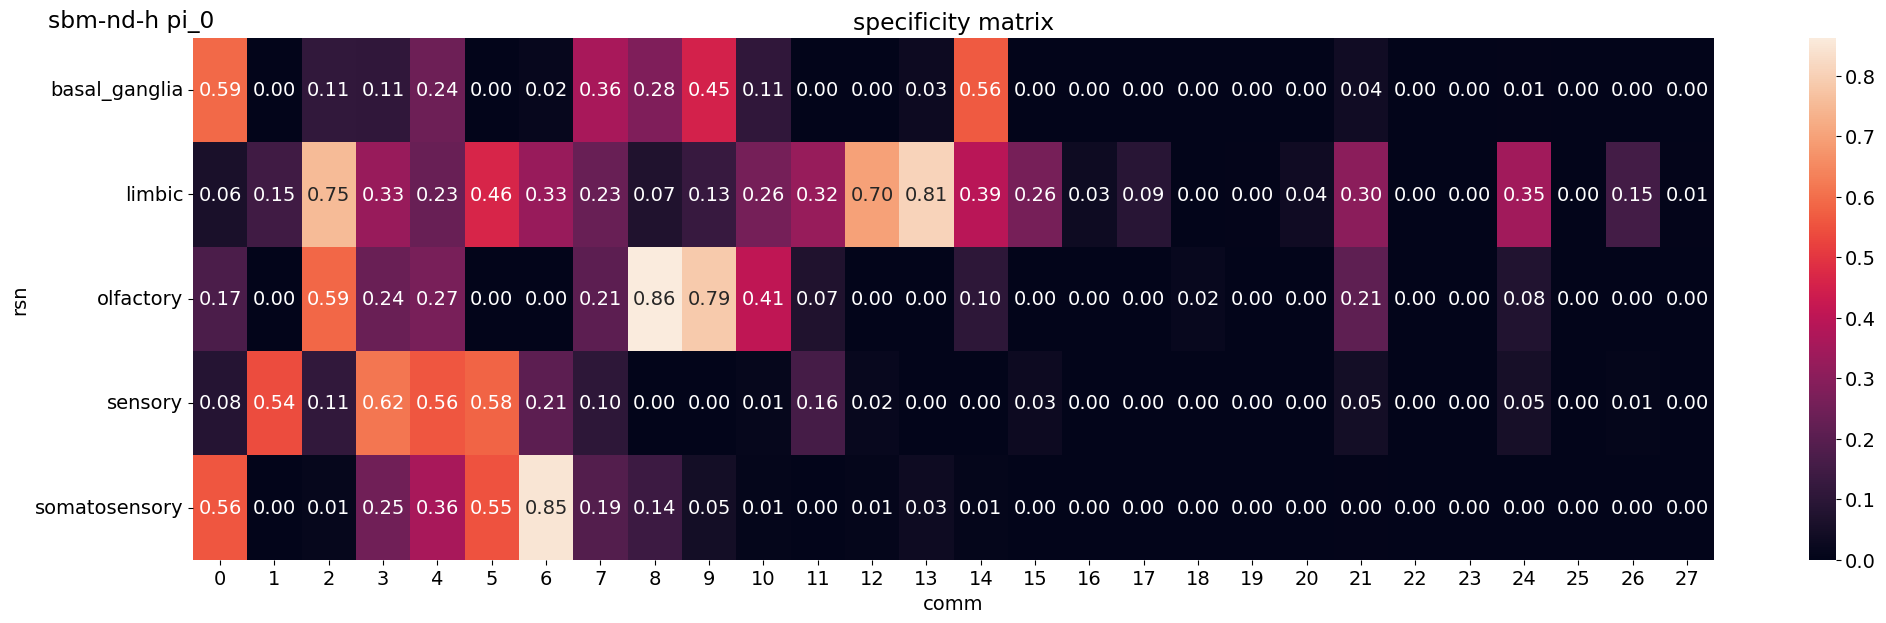

In [25]:
ncols = 1
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(20*ncols, 6*nrows),)
fig.tight_layout(h_pad=3, w_pad=3)
fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)
ax = axs
mean_X = np.mean(Xs, axis=1)
sns.heatmap(mean_X, ax=ax, annot=True, fmt='.2f', yticklabels=sys_names)
ax.set(xlabel=f'comm', ylabel=f'{sys_name}', title=f'specificity matrix')

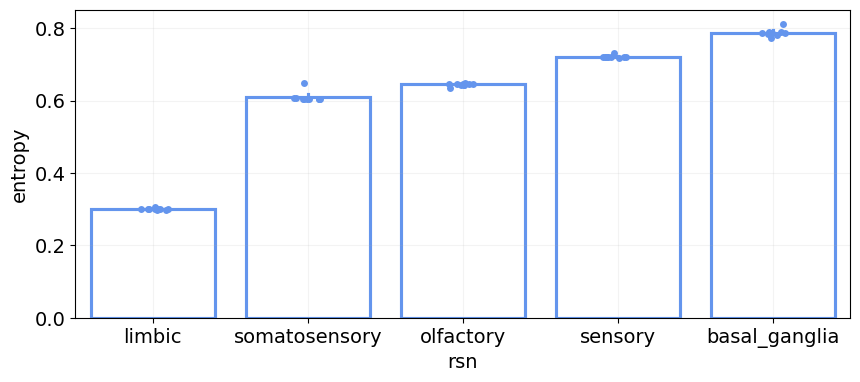

In [26]:
df = rsn_ent_df
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.barplot(df.sort_values(by='entropy'), x='rsn', y='entropy', orient='v', ax=ax, fill=False, alpha=1.0, color='cornflowerblue')
sns.stripplot(df, x='rsn', y='entropy', orient='v', ax=ax, color='cornflowerblue', size=5)
ax.grid(alpha=0.15)

covering RSNs with groups of comms.

In [27]:
def analyze_rsn_coverage(spec_matrices, cov_matrices):
    """Get assignments from specificity and total coverage from coverage matrices."""
    # Assign using specificity
    assignments = [np.argmax(spec, axis=0) for spec in spec_matrices]
    
    # Calculate total coverage from coverage matrices, 
    # per animal then their average
    coverages = []
    for cov_mat, assign in zip(cov_matrices, assignments):
        rsn_coverage = np.array([
            np.sum(cov_mat[rsn, assign==rsn]) 
            for rsn in range(cov_mat.shape[0])
        ])
        coverages.append(rsn_coverage)
    
    # Get consensus
    ref_assignments = stats.mode(assignments, axis=0)[0]
    mean_coverage = np.mean(coverages, axis=0)
    
    return ref_assignments, mean_coverage, np.stack(coverages, axis=0)

def bootstrap_coverage(spec_matrices, cov_matrices, num_bootstrap=100):
    """Bootstrap stability analysis."""
    num_animals = len(spec_matrices)
    ref_assignments, ref_coverage, ref_covs = analyze_rsn_coverage(spec_matrices, cov_matrices)
    
    coverage_dist = []
    for _ in range(num_bootstrap):
        indices = np.random.choice(num_animals, num_animals, replace=True)
        boot_spec = [spec_matrices[i] for i in indices]
        boot_cov = [cov_matrices[i] for i in indices]
        _, boot_coverage, _ = analyze_rsn_coverage(boot_spec, boot_cov)
        coverage_dist.append(boot_coverage)
    
    coverage_ci = np.percentile(coverage_dist, [2.5, 97.5], axis=0)
    
    return ref_assignments, ref_coverage, ref_covs, coverage_ci

In [28]:
num_clusters = len(rsn_files)
folder = f'{ESTIM_path}/group/comparisons-with-known-systems/{SBM}/num-clusters-{num_clusters}/nii'
os.system(f'mkdir -p {folder}')

sys_name = 'rsn'
sys_names = [rsn_file.split('/')[-1].split('-')[2] for rsn_file in rsn_files]
for col in cols[:1]:
    Xs = get_membership_matrix(len(rsn_files), soft_specificities_to_rsns_df, col=col)
    spec_matrices = [Xs[:, i, :] for i in range(Xs.shape[1])]
    Ys = get_membership_matrix(len(rsn_files), soft_coverages_of_rsns_df, col=col)
    cov_matrices = [Ys[:, i, :] for i in range(Ys.shape[1])]
    assigns, mean_coverages, animal_coverages, coverages_ci = bootstrap_coverage(spec_matrices, cov_matrices, num_bootstrap=100) 
    with open(f'{folder}/../col-{col}_sys-{sys_name}_desc-rsn-coverages.pkl', 'wb') as f:
        pickle.dump(
            (assigns, mean_coverages, animal_coverages, coverages_ci), 
            f
        )

[Text(0.5, 15.444444444444445, 'comm'),
 Text(26.444444444444436, 0.5, 'rsn'),
 Text(0.5, 1.0, 'coverage matrix')]

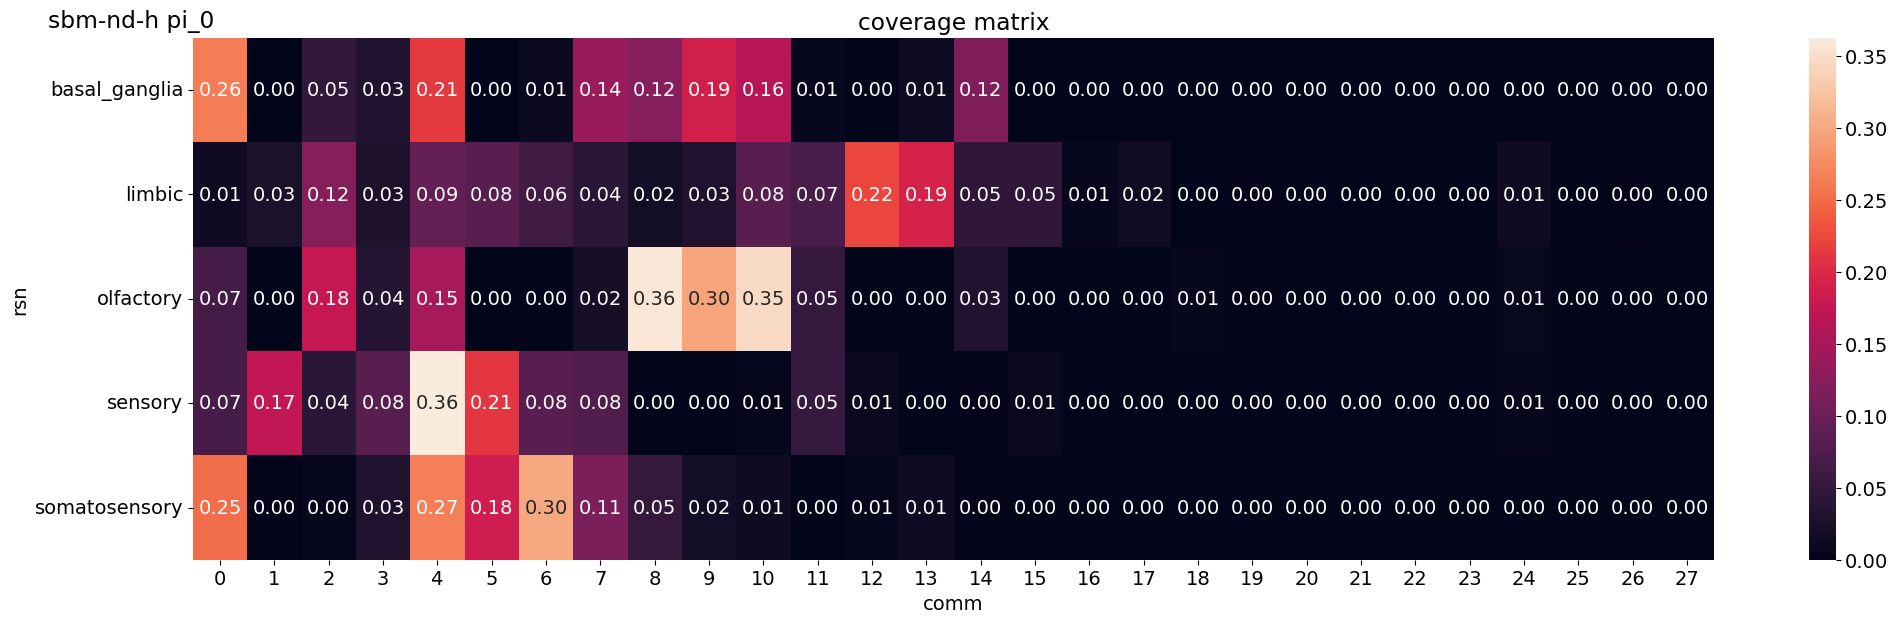

In [29]:
ncols = 1
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(20*ncols, 6*nrows),)
fig.tight_layout(h_pad=3, w_pad=3)
fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)
ax = axs
mean_Y = np.mean(Ys, axis=1)
sns.heatmap(mean_Y, ax=ax, annot=True, fmt='.2f', yticklabels=sys_names)
ax.set(xlabel=f'comm', ylabel=f'{sys_name}', title=f'coverage matrix')

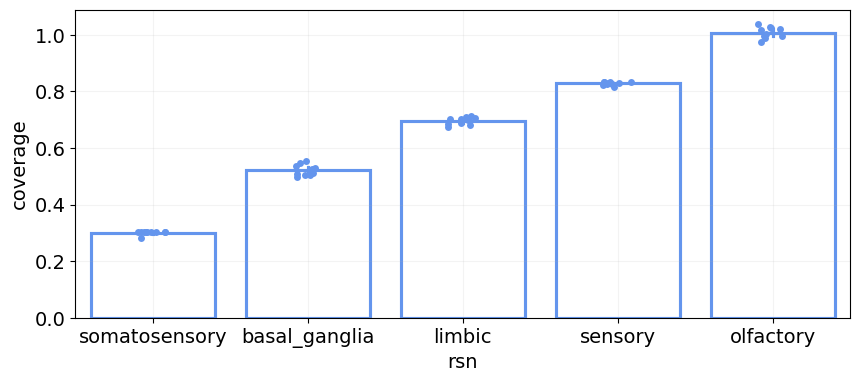

In [30]:
df = {f'rsn':[], f'coverage':[]}
for rsn in range(animal_coverages.shape[-1]):
    rsn_covs = animal_coverages[:, rsn]
    df[f'coverage'].append(rsn_covs)
    df[f'rsn'].append([sys_names[rsn]]*len(rsn_covs))
df = pd.DataFrame(df)
df = df.explode(['rsn', 'coverage']).reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.barplot(df.sort_values(by='coverage'), x='rsn', y='coverage', orient='v', ax=ax, fill=False, alpha=1.0, color='cornflowerblue')
sns.stripplot(df, x='rsn', y='coverage', orient='v', ax=ax, color='cornflowerblue', size=5)
ax.grid(alpha=0.15)

comm resemblance/correspondence with IC

In [31]:
ic_files = sorted(glob.glob(f'{IC_ROI_path}/*-mask*.nii.gz', recursive=True))
correspondences_to_ics_df = get_similarity_matrix(nii_files, ic_files, metric='F1')
soft_correspondences_to_ics_df = get_soft_similarity_matrix(correspondences_to_ics_df, len(ic_files))

100%|██████████| 403/403 [01:26<00:00,  4.68it/s]


In [32]:
folder = f'{ESTIM_path}/group/comparisons-with-known-systems/{SBM}'
os.system(f'mkdir -p {folder}')

sys_name = 'ic'
sys_names = [ic_file.split('/')[-1].split('-')[2] for ic_file in ic_files]
for col in tqdm(cols):
    ncols = 1
    nrows = len(soft_correspondences_to_ics_df)
    fig, axs = plt.subplots(nrows, ncols, figsize=(20*ncols, 6*nrows),)
    fig.tight_layout(h_pad=3, w_pad=3)
    fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)
    for idx, row in soft_correspondences_to_ics_df.iterrows():
        r = idx
        ax = axs[r]
        sub = row['sub']
        soft_X = row[col]
        sns.heatmap(soft_X, ax=ax, vmin=0.0, vmax=1.0, annot=True, fmt='.2f', yticklabels=sys_names)
        ax.set(xlabel=f'comm', ylabel=f'{sys_name}', title=f'{sub}: correspondence matrix')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        
    fig.savefig(f'{folder}/col-{col}_sys-{sys_name}_desc-correspondence-matrices.pdf', bbox_inches='tight')
    plt.close('all')

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:11<00:00,  7.89s/it]


In [33]:
for sub, group in correspondences_to_ics_df.groupby('sub'):
    folder = f'{ESTIM_path}/individual/sub-{sub}/comparions-with-known-systems/{SBM}'
    os.system(f'mkdir -p {folder}')

    with open(f'{folder}/sys-ic_desc-correspondences.pkl', 'wb') as f:
        pickle.dump(group, f)

In [34]:
def find_consistent_correspondences(matrices, threshold=0.5):
    mean_matrix = np.mean(matrices, axis=0)
    high_scores = (mean_matrix > threshold).astype(int)
    return mean_matrix, high_scores

def bootstrap_correspondence(matrices, threshold=0.5, num_bootstrap=100):
    num_animals = len(matrices)
    ref_matrix, ref_high_scores = find_consistent_correspondences(matrices, threshold, )

    boot_results = [
        find_consistent_correspondences(
            [matrices[i] for i in np.random.choice(num_animals, num_animals, replace=True)], 
            threshold,
        )
        for _ in range(num_bootstrap)
    ]
    
    boot_matrices, boot_high_scores = list(zip(*boot_results))
    mean_matrix = np.mean(boot_matrices, axis=0)
    mean_high_scores = np.mean(boot_high_scores)
    matrix_ci = np.percentile(boot_matrices, [2.5, 97.5], axis=0)
    high_score_ci = np.percentile(boot_high_scores, [2.5, 97.5], axis=0)
    return ref_matrix, matrix_ci, ref_high_scores, high_score_ci,

In [36]:
num_clusters = len(ic_files)
folder = f'{ESTIM_path}/group/comparisons-with-known-systems/{SBM}/num-clusters-{num_clusters}/nii'
os.system(f'mkdir -p {folder}')

sys_name = 'ic'
sys_names = [ic_file.split('/')[-1].split('-')[2] for ic_file in ic_files]
for col in cols[:1]:
    Xs = get_membership_matrix(len(ic_files), soft_correspondences_to_ics_df, col=col)
    matrices = [Xs[:, i, :] for i in range(Xs.shape[1])]

    (
        mean_matrix, matrix_ci,
        mean_high_scores, high_score_ci,
    ) = bootstrap_correspondence(matrices, threshold=0.5)
    with open(f'{folder}/../col-{col}_sys-{sys_name}_desc-correspondences.pkl', 'wb') as f:
        pickle.dump(
            (
                mean_matrix, matrix_ci,
                mean_high_scores, high_score_ci,
            ),
            f
        )
    
    # correspondence entropy
    ents, _, ents_ci, _ = bootstrap_assignment_entropy(matrices, num_bootstrap=100)
    ents, ents_ci
    
    # high correspondence pairs
    hc_ics, hc_comms = np.where(matrix_ci[0] > 0.5)
    pd.DataFrame({'ic':hc_ics, 'comm':hc_comms, 'ent':ents[hc_comms]}).to_csv(f'{folder}/../col-{col}_sys-{sys_name}_desc-high-correspondence-comms.csv')

    

[Text(0.5, 15.444444444444445, 'comm'),
 Text(27.444444444444443, 0.5, 'ic'),
 Text(0.5, 1.0, 'correspondence matrix')]

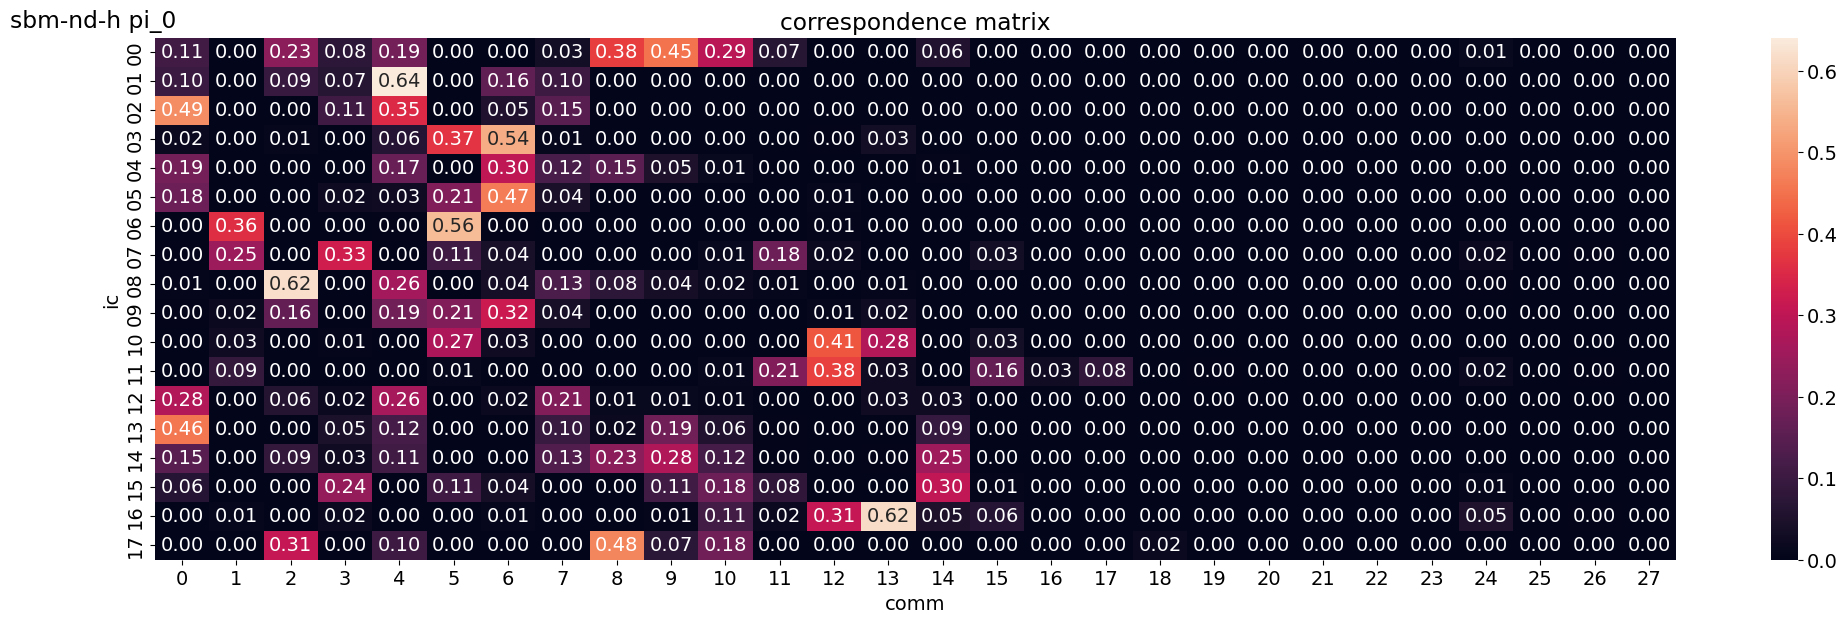

In [39]:
ncols = 1
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(20*ncols, 6*nrows),)
fig.tight_layout(h_pad=3, w_pad=3)
fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)
ax = axs
mean_X = np.mean(Xs, axis=1)
sns.heatmap(mean_X, ax=ax, annot=True, fmt='.2f', yticklabels=sys_names)
ax.set(xlabel=f'comm', ylabel=f'{sys_name}', title=f'correspondence matrix')

---

In [17]:
def selected_comms_in_group(Xs, thresh=0.1):
    sel_comms = []
    for X in Xs:
        scs = np.sum(X, axis=0) > thresh
        scs = np.where(scs)[0]
        sel_comms += [scs]
    lens = list(map(len, sel_comms))
    loc = np.where(lens == np.min(lens))[0][0]
    sel_comms = sel_comms[loc]
    return sel_comms

In [18]:
def align_labels(labels_to_align, reference_labels, num_clusters):
    """
    Align labels_to_align with reference_labels using Hungarian algorithm.
    """
    cost_matrix = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            mask_i = labels_to_align == i
            mask_j = reference_labels == j
            cost_matrix[i,j] = -np.sum(mask_i & mask_j)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    aligned_labels = np.zeros_like(labels_to_align)
    for old_label, new_label in zip(row_ind, col_ind):
        aligned_labels[labels_to_align == old_label] = new_label
    return aligned_labels

def compute_block_matrix(matrices, row_labels, col_labels, num_clusters):
    """
    Compute block matrix
    
    Args:
        matrices: List of matrices
        row_labels: Row cluster labels
        col_labels: Column cluster labels
        n_clusters: Number of clusters
    Returns:
        block_matrix: Average values within each block (n_clusters, n_clusters)
    """
    block_matrix = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            row_mask = (row_labels == i)
            col_mask = (col_labels == j)
            block_matrix[i,j] = np.mean([mat[row_mask][:, col_mask] for mat in matrices])
    return block_matrix

def consensus_coclustering(matrices, num_clusters, compute_block_pattern=False):
    """
    Get consensus labels, with optional block pattern computation.
    Only compute block pattern for reference labels, skip for bootstrap.
    """
    # Get individual coclusterings
    models = [SpectralCoclustering(n_clusters=num_clusters, random_state=0).fit(mat) for mat in matrices]

    # Build consensus matrices
    n_rows, n_cols = matrices[0].shape
    row_labels = [model.row_labels_ for model in models]
    col_labels = [model.column_labels_ for model in models]

    row_consensus = np.mean([np.eye(n_rows)[labels][:, labels] for labels in row_labels], axis=0)
    col_consensus = np.mean([np.eye(n_cols)[labels][:, labels] for labels in col_labels], axis=0)

    # Get consensus labels
    final_rows = SpectralClustering(n_clusters=num_clusters, affinity='precomputed').fit_predict(row_consensus)
    final_cols = SpectralClustering(n_clusters=num_clusters, affinity='precomputed').fit_predict(col_consensus)

    if compute_block_pattern:
        # Compute block pattern only for reference
        block_matrix = compute_block_matrix(matrices, final_rows, final_cols, num_clusters)
        return final_rows, final_cols, block_matrix
    
    return final_rows, final_cols

def align_row_col_labels(row_labels, col_labels, block_pattern, n_clusters):
    """
    Align column labels to row labels based on block pattern.
    """
    _, col_ind = linear_sum_assignment(-block_pattern)
    col_mapping = np.zeros_like(col_ind)
    col_mapping[col_ind] = np.arange(n_clusters)
    aligned_cols = col_mapping[col_labels]

    return row_labels, aligned_cols

def compute_element_stability(ref_labels, boot_labels_list):
    """
    Compute stability of cluster assignment for each element.

    Args:
        ref_labels: Reference labels
        boot_labels_list: List of labels from bootstrap samples
    Returns:
        element_stability: Array of stability scores for each element
    """
    boot_labels = np.array(boot_labels_list)
    matches = (boot_labels == ref_labels[np.newaxis, :])
    element_stability = np.mean(matches, axis=0)
    return element_stability

def bootstrap_consensus(matrices, num_clusters, n_bootstrap=100):
    """
    Bootstrap with stability analysis.

    Returns:
        ref_rows: Reference row labels
        ref_cols: Reference column labels
        mean_pattern: Mean block pattern
        ci_<lower, upper>: 95% CI around mean_pattern
        row_stability: Stability matrix for rows
        col_stability: Stability matrix for columns
        row_element_stability: Individual stability for each row
        col_element_stability: Individual stability for each column
    """
    ref_rows, ref_cols, ref_pattern = consensus_coclustering(matrices, num_clusters, compute_block_pattern=True)
    ref_rows, ref_cols = align_row_col_labels(ref_rows, ref_cols, ref_pattern, num_clusters)

    n_rows, n_cols = matrices[0].shape
    row_stability = np.zeros((n_rows, n_rows))
    col_stability = np.zeros((n_cols, n_cols))
    
    boot_row_labels = []
    boot_col_labels = []
    block_patterns = []

    for _ in tqdm(range(n_bootstrap)):
        indices = np.random.choice(len(matrices), size=len(matrices), replace=True)
        boot_matrices = [matrices[i] for i in indices]
        
        boot_rows, boot_cols = consensus_coclustering(boot_matrices, num_clusters, compute_block_pattern=False)
        aligned_rows = align_labels(boot_rows, ref_rows, num_clusters)
        aligned_cols = align_labels(boot_cols, ref_cols, num_clusters)
        
        # co-occurrence matrix
        row_stability += np.eye(n_rows)[aligned_rows][:, aligned_rows]
        col_stability += np.eye(n_cols)[aligned_cols][:, aligned_cols]
        
        boot_row_labels.append(aligned_rows)
        boot_col_labels.append(aligned_cols)
        
        block_matrix = compute_block_matrix(boot_matrices, aligned_rows, aligned_cols, num_clusters)
        block_patterns.append(block_matrix)
    
    row_stability /= n_bootstrap
    col_stability /= n_bootstrap

    row_element_stability = compute_element_stability(ref_rows, boot_row_labels)
    col_element_stability = compute_element_stability(ref_cols, boot_col_labels)

    mean_pattern = np.mean(block_patterns, axis=0)
    ci_lower = np.percentile(block_patterns, 2.5, axis=0)
    ci_upper = np.percentile(block_patterns, 97.5, axis=0)

    return (
        ref_rows, ref_cols, mean_pattern, ci_lower, ci_upper, 
        row_stability, col_stability, 
        row_element_stability, col_element_stability,
    )

In [ ]:
# save ic/rsn groups
def group_icimg(ic_files, ics):
        icvols = []
        for ic in ics:
            icimg =ants.image_read(ic_files[ic]) 
            icvols += [icimg.numpy()]
        grp_icvol = np.sum(np.stack(icvols, axis=-1), axis=-1)
        grp_icvol = (grp_icvol > 0).astype(np.float32)
        return icimg.new_image_like(grp_icvol)

def save_sys_groups(ic_files, num_clusters, row_labels, sys_name='ic'):
    for i in range(num_clusters):
        ics = np.where(row_labels == i)[0]
        grp_icimg = group_icimg(ic_files, ics)
        grp_icimg.to_file(f'{folder}/group-{i:02d}.nii.gz')

    in_files = sorted(glob.glob(f'{folder}/group-*.nii.gz'))
    out_file = f'{folder}/sys-{sys_name}_desc-sys-groups.nii.gz'
    concatenate(in_files, out_file)
    return None

# save comm groups
def save_comm_groups(num_clusters, sel_comms, col_labels, sys_name='ic'):

    cmask_img = ants.image_read(
        f'{BASE_path}/voxel/common_brain_mask.nii.gz'
    )

    col = cols[0]
    level = col.split('_')[-1]
    if level == 'aligned':
        name = f'mode-00'
    else:
        name = f'mode-00_level-{level}'

    # these comm files are only for visualization purposes
    comms_file = sorted(glob.glob(f'{ESTIM_path}/group/membership-mats-group-aligned/{SBM}/marginal-visuals/nii/{name}.nii.gz'))[0]
    comms_vol = ants.image_read(comms_file).numpy()

    for i in range(num_clusters):
        comms = sel_comms[col_labels == i]
        grp_comms_vol = np.sum(comms_vol[..., comms], axis=-1)
        cmask_img.new_image_like(grp_comms_vol).to_file(
            f'{folder}/group-{i:02d}.nii.gz'
        )
    in_files = sorted(glob.glob(f'{folder}/group-*.nii.gz'))
    out_file = f'{folder}/sys-{sys_name}_desc-comm-groups.nii.gz'
    concatenate(in_files, out_file)
    return None

In [21]:
# resemblance to rsns
num_clusters=4

folder = f'{ESTIM_path}/group/comparisons-with-known-systems/{SBM}/nii/num-clusters-{num_clusters}'
os.system(f'mkdir -p {folder}')

sys_name = 'rsn'
sys_names = [rsn_file.split('/')[-1].split('-')[2] for rsn_file in rsn_files]
for col in cols[:1]:
    Xs = soft_specificities_to_rsns_df[col].to_list()
    sel_comms = selected_comms_in_group(Xs)
    Xs = [X[:, sel_comms] for X in Xs]

    (
        row_labels, col_labels, mean_pat, ci_lower, ci_upper,
        row_stability, col_stability,
        row_element_stability, col_element_stability,
    ) = bootstrap_consensus(matrices=Xs, num_clusters=num_clusters, n_bootstrap=100)

    # create nii files for the groups and then open them side-by-side
    # save_sys_groups(rsn_files, num_clusters, row_labels, sys_name)
    # save_comm_groups(num_clusters, sel_comms, col_labels, sys_name)

100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


<Axes: >

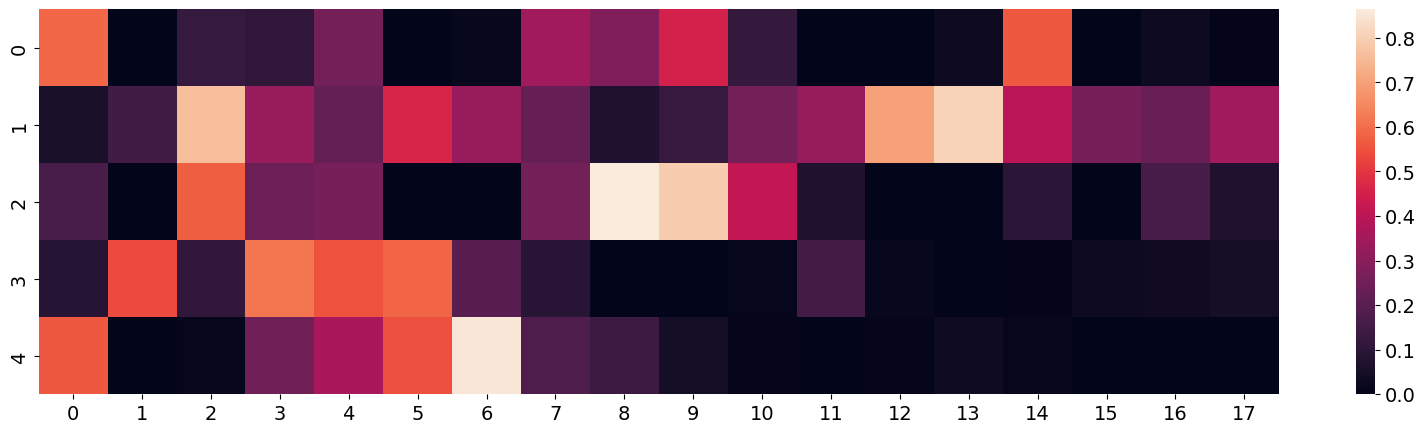

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.heatmap(Xs[0], ax=ax)

In [23]:
row_labels, list(zip(sel_comms, col_labels))

(array([0, 2, 0, 3, 1], dtype=int32),
 [(0, 0),
  (1, 3),
  (2, 1),
  (3, 3),
  (4, 3),
  (5, 3),
  (6, 3),
  (7, 0),
  (8, 0),
  (9, 0),
  (10, 1),
  (11, 2),
  (12, 2),
  (13, 2),
  (14, 0),
  (15, 2),
  (21, 1),
  (24, 2)])

In [25]:
Xs[0]

array([[5.88020245e-01, 0.00000000e+00, 1.22264742e-01, 1.08837699e-01,
        2.54011674e-01, 5.02491175e-04, 1.60671887e-02, 3.45704200e-01,
        2.77134600e-01, 4.52680885e-01, 1.18548710e-01, 2.86044851e-03,
        0.00000000e+00, 2.81722856e-02, 5.62485585e-01, 0.00000000e+00,
        2.90292736e-02, 5.16104690e-03],
       [5.85876569e-02, 1.45604398e-01, 7.60472602e-01, 3.27649921e-01,
        2.23471510e-01, 4.64467899e-01, 3.28070191e-01, 2.28088392e-01,
        7.38645480e-02, 1.25635773e-01, 2.54795709e-01, 3.22159418e-01,
        6.99055845e-01, 8.06909376e-01, 3.95141982e-01, 2.60224777e-01,
        2.35032207e-01, 3.45031990e-01],
       [1.68670070e-01, 0.00000000e+00, 5.72571872e-01, 2.38132337e-01,
        2.62487968e-01, 0.00000000e+00, 3.81927636e-04, 2.54831463e-01,
        8.63992977e-01, 7.91427137e-01, 4.13224745e-01, 7.33044921e-02,
        0.00000000e+00, 0.00000000e+00, 9.97340787e-02, 0.00000000e+00,
        1.64102846e-01, 7.33707527e-02],
       [8.586

<Axes: >

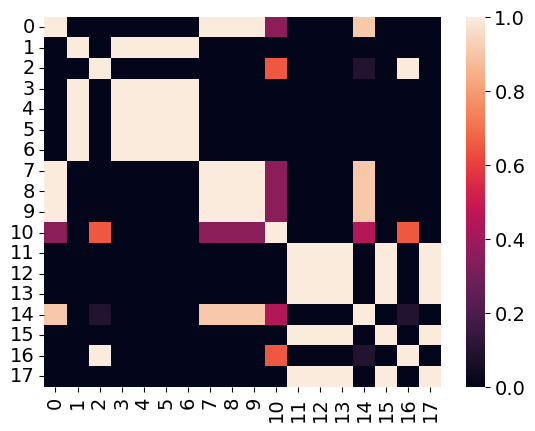

In [ ]:
sns.heatmap(col_stability)

---

In [78]:
X = Xs[0]
model = SpectralCoclustering(n_clusters=5, random_state=0).fit(X)
model.row_labels_, list(zip(sel_comms, model.column_labels_,))

(array([0, 2, 0, 1, 1], dtype=int32),
 [(0, 0),
  (1, 1),
  (2, 3),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 0),
  (8, 0),
  (9, 0),
  (10, 3),
  (11, 2),
  (12, 2),
  (13, 2),
  (14, 3),
  (15, 2),
  (21, 3),
  (24, 2)])

In [79]:
(model.rows_).astype(int)

array([[1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])